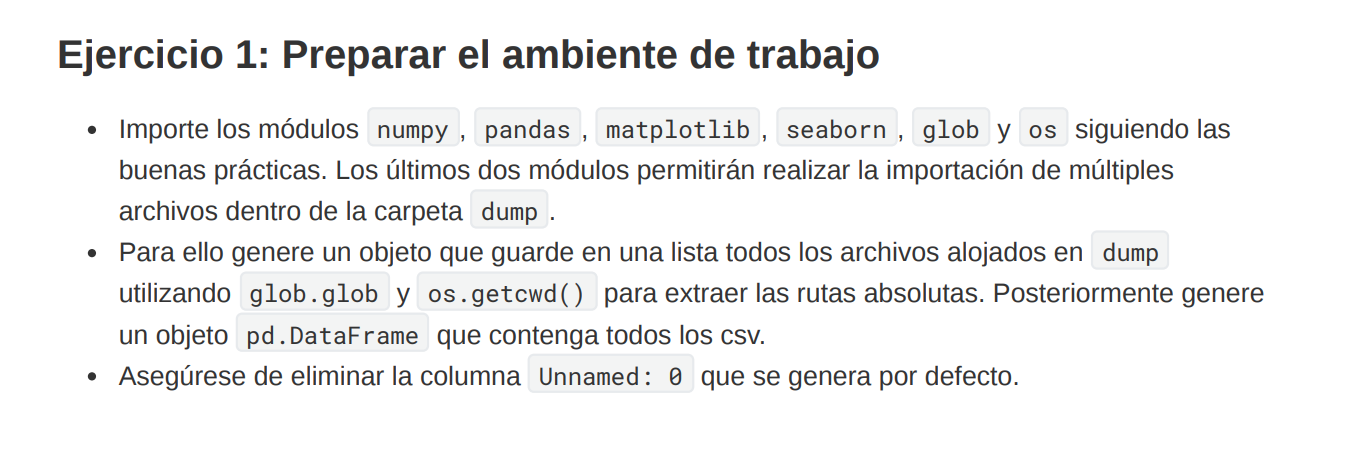

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import warnings
plt.style.use("ggplot")

warnings.filterwarnings(action='ignore')

In [2]:
os.getcwd()

'/Users/alexandrabobet/Downloads/Desafio Bayes'

In [3]:
path_files = os.getcwd() + "/dump/"

In [4]:
path_files

'/Users/alexandrabobet/Downloads/Desafio Bayes/dump/'

In [5]:
dfs = glob.glob(path_files + "*.csv")

In [6]:
# Leer archivos en ruta dump


li = []

for filename in dfs:
    df_file = pd.read_csv(filename, index_col=0)
    li.append(df_file)

df = pd.concat(li, ignore_index=True)
df.columns = ["artist", "genre", "song", "lyrics"]
display(df.head())

artist   genre                    song  \
0  Public Enemy  hiphop  You're Gonna Get Yours   
1  Public Enemy  hiphop     Sophisticated Bitch   
2  Public Enemy  hiphop      Miuzi Weighs A Ton   
3  Public Enemy  hiphop                Timebomb   
4  Public Enemy  hiphop          Too Much Posse   

                                              lyrics  
0  (Flavor Flav) \n Oh-oh Chuck, they out to get ...  
1  That woman in the corner, cold playin' the rol...  
2  Yo Chuck, run a power move on them \n (Yeah) \...  
3  (Intro - Flavor Flav) \n Hey, Chuck, we got so...  
4  (Intro - Flavor Flav) \n What do you got to sa...

Text(0.5, 1.0, 'Cantidad de canciones registradas por género')

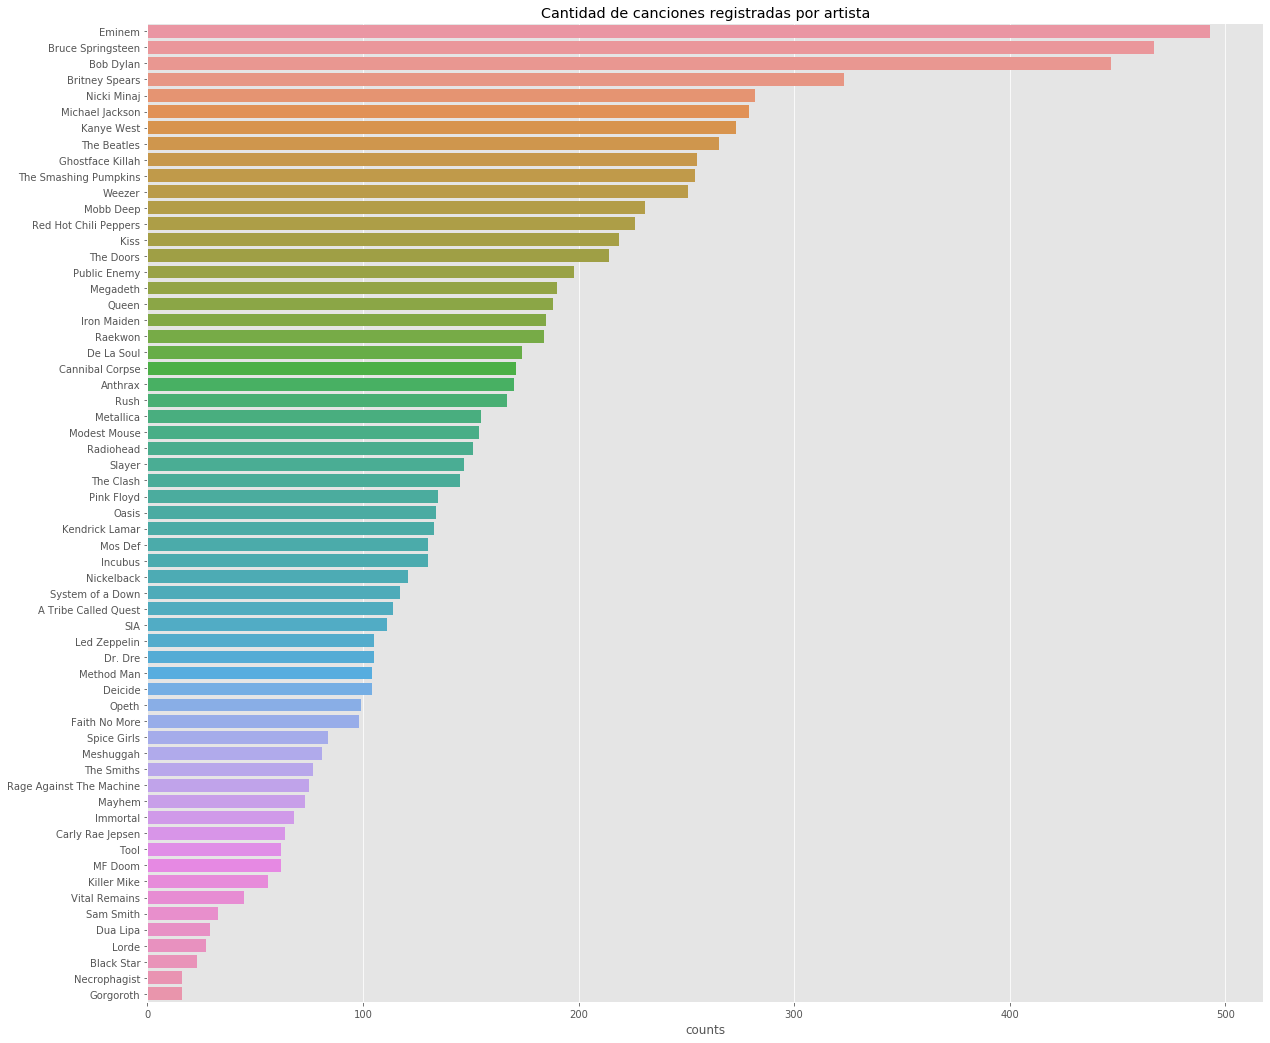

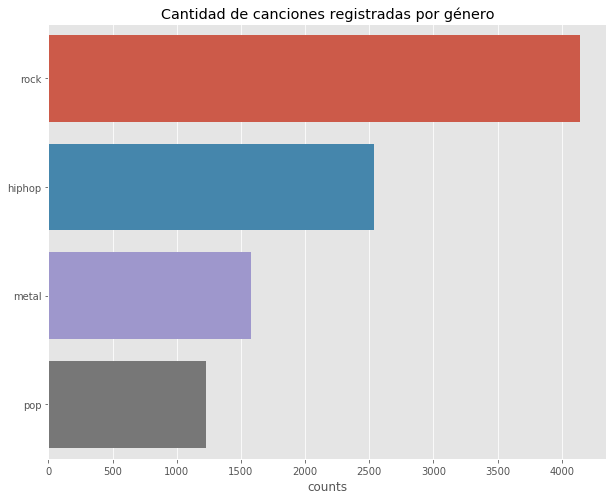

In [7]:
songs = pd.DataFrame(data={"counts": df["artist"].value_counts()})
genre = pd.DataFrame(data={"counts": df["genre"].value_counts()})

plt.figure(figsize=(20,18))
barplot_art = sns.barplot( x="counts", y=songs.index, data=songs)
barplot_art.set_title('Cantidad de canciones registradas por artista')

plt.figure(figsize = (10,8))
barplot_gen = sns.barplot( x="counts", y=genre.index, data=genre)
barplot_gen.set_title('Cantidad de canciones registradas por género')

### Comentarios:

- Se observa que rock es el género con más canciones, seguido por el hiphop. Las artistas con más canciones el top 3 son: Eminem(hip-hop), Bruce Springsteen(rock) y Bob Dylan(rock) con más de 400 canciones.

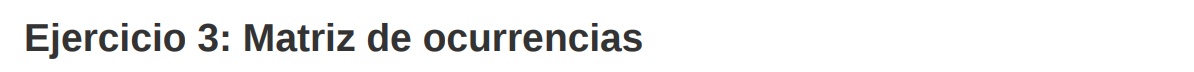

In [8]:
# Reemplazamos ciertas simbologías propias del inglés para dejar sólo letras y le quitamos las mayúsculas
df["lyrics"] = df['lyrics'].str.replace(r'[^\w\s]','')
df['lyrics']=df['lyrics'].apply(lambda x: x.lower())

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

def most_common_words(df):
    ''' Función para contabilizar la cantida de veces que se repite una palabra en general
    '''
    count_vectorizer = CountVectorizer(stop_words='english')
    count_vectorizer_fit = count_vectorizer.fit_transform(df["lyrics"])
    words = count_vectorizer.get_feature_names()
    words_freq = count_vectorizer_fit.toarray().sum(axis=0)
    return pd.DataFrame({ 'counts': words_freq }, index=words).sort_values(by='counts', ascending=False)[:100]

In [10]:
df_words = most_common_words(df)

In [11]:
plt.figure(figsize=(20, 30))
barplot_gen = sns.barplot(x="counts", y = df_words.index, data= df_words)
barplot_gen.set_title('100 Palabras más frecuentes para todos los generos')

Text(0.5, 1.0, '100 Palabras más frecuentes para todos los generos')

In [12]:
def count_genero(genero):
    ''' Función para contabilizar la cantida de veces que se repite una palabra acorde al genero
    '''
    # instanciamos un objeto
    count_vectorizer=CountVectorizer(stop_words='english')
    # Implementamos los pasos fit y transform

    count_vectorizer_fit = count_vectorizer.fit_transform(df[df["genre"]==genero]["lyrics"])
    # Extraemos tokens (palabras)
    words = count_vectorizer.get_feature_names()
# extraemos frecuencia
    words_freq = count_vectorizer_fit.toarray().sum(axis=0)
    df1 = pd.DataFrame({'Words': words,'Freq.': words_freq})
    df2 = df1.sort_values(by =['Freq.'], ascending=False)
    
    df2=df2.reset_index(drop=True)
    df_words=df2[:100]
    df_words
    return(df_words)

In [13]:
df_rock = count_genero('rock')
df_rap = count_genero('hiphop')
df_metal = count_genero('metal')
df_pop =count_genero('pop')

In [14]:
dfs = [df_rock, df_rap, df_metal, df_pop]

df_combined = pd.concat(
    [df.rename(columns=lambda x: x.zfill(4)) for df in dfs],
    keys=['Rock','HipHop','Metal','Pop'],
    axis=1
)
dfStyler=df_combined.style.set_properties(**{'text-align': 'center'})
dfStyler.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

### Comentarios:

- Al aplicar la opción stop_words permite eliminar las palabras que sólo conectan frases (cómo artículos, etc).
- A primera vista, existe muchas palabras en comun entre los géneros, como **im* y **like**.
- Sin embargo, empieza a diversificar despues de la 4ta fila. 
 * Para Rock, la palabra **Love** y **Yeah** son de las principales.  
 * Para Hip-hop, empieza a cambiar en la fila 6 con **shit** y **aint** un modismo popular en el vernaculo afroamericano. 
 * Las bandas de metal tienen letras de canciones que se refieren a temas ocultos y a la muerte, por lo cual despues de la 3ra fila empieza a diversificar con **death**, **blood** y **die**
 * Para el pop, tiene una tendencia parecida a Rock, utilizando palabras como **Love** y **baby**

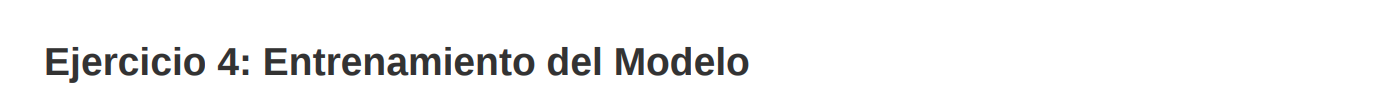

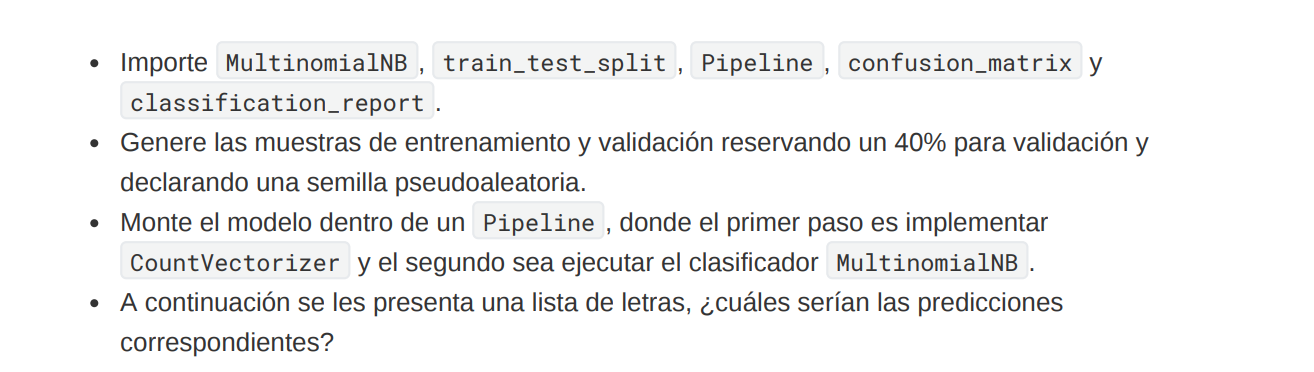

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [16]:
#genere las muestras de entrenamiento y validación reservando un 40% para validación y declarando una semilla pseudoaleatoria


y = df['genre']
X = df['lyrics']

X_train, X_test, y_train, y_test, = train_test_split(
    X, y, test_size=0.4, random_state=993177)

#monte el modelo dentro de un Pipeline , donde el primer paso es implementar CountVectorizer y el segundo sea ejecutar el clasificador MultinomialNB .

pipeline_model = Pipeline([
    ('counter', CountVectorizer(stop_words='english',  max_features=100)),
    ('model', MultinomialNB())
])

pipeline_model.fit(X_train, y_train);

In [17]:
#generar las predicciones solicitadas:

to_predict = ['I got a place in the underworld', # Brody Dalle - Underworld
'As veils of ignorance, hatred retains Storm of arrows through karma Seeking light through samsara', # Gorguts - Forgotten Arrows
"Bye bye Don't want to be a fool for you Just another player in your game for two You may hate me but it ain't no lie", # N'SYNC - Bye Bye Bye
'Move bitch, get out the way Get out the way bitch, get out the way Move bitch, get out the way Get out the way bitch, get out the way', # Ludacris -Move B*tch
'Sexual violence doesn’t start and end with rape It starts in our books and behind our school gates' # IDLES - Mother,
"Take it from the girl you claimed to love You gonna get some bad karma I'm the one who had to learn to build a heart made of armor From the girl who made you soup and tied your shoes when you were hurting You are not deserving, you are not deserving" #Banks -Drowning
]

print('Las predicciones solicitadas, respectivamente, son:', ', '.join(pipeline_model.predict(to_predict)))

Las predicciones solicitadas, respectivamente, son: rock, rock, rock, hiphop, rock


In [18]:
#genera predicciones de la muestra

predict_genre = pipeline_model.predict(to_predict)

reales = ["rock", "metal", "pop", "hiphop", "pop"]

summary = pd.DataFrame(data={
    "lyrics": to_predict,
    "genre predicted": predict_genre,
    "real genre": reales
    }
)

print(summary)

                                              lyrics genre predicted  \
0                    I got a place in the underworld            rock   
1  As veils of ignorance, hatred retains Storm of...            rock   
2  Bye bye Don't want to be a fool for you Just a...            rock   
3  Move bitch, get out the way Get out the way bi...          hiphop   
4  Sexual violence doesn’t start and end with rap...            rock   

  real genre  
0       rock  
1      metal  
2        pop  
3     hiphop  
4        pop  


- Comparando las columnas *genre predicted* y *real genre* las muestras el modelo no tuvo buena predicción para el metal y el pop.

In [19]:
#ahora para el conjunto de test:

y_hat = pipeline_model.predict(X_test)

              precision    recall  f1-score   support

      hiphop       0.78      0.82      0.80      1026
       metal       0.56      0.72      0.63       631
         pop       0.38      0.31      0.34       519
        rock       0.71      0.64      0.67      1620

    accuracy                           0.66      3796
   macro avg       0.61      0.63      0.61      3796
weighted avg       0.66      0.66      0.66      3796



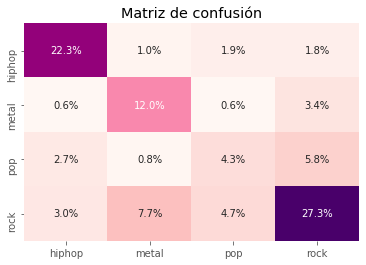

In [20]:
print(classification_report(y_test, y_hat))

cnf = confusion_matrix(y_test, y_hat) / len(y_test)
plt.title('Matriz de confusión')
sns.heatmap(cnf, xticklabels=pipeline_model.classes_, yticklabels=pipeline_model.classes_, annot=True, fmt=".1%", cbar=False, cmap='RdPu');

### Comentarios: 

La precisión de cada género es:
* hiphop: 78%.
* metal: 56%
* pop: 36%
* rock: 70%


La precisión más baja la tiene el pop y el metal, lo que coincido con los resultados obtenidos de la muestra de 5 letras. Este modelo clasifica de forma correcta alrededor del 65% de los casos. Que resulta bastantes bajo.
Se prueba nuevamente esta vez eliminando la restricción de 100 palabras.

### Estrategia:

- Para mejorar el desempeño del modelo, con bajo rendimiento en el pop, se requieren más datos. Se agregan, adicionalmente, los datos de la carpeta **dump_plus_pop**.

In [21]:
files = glob.glob("./dump*/*.csv", recursive=True)

li = []

for filename in files:
    df_file = pd.read_csv(filename, index_col=0)
    li.append(df_file)

df = pd.concat(li, ignore_index=True)
df.columns = ["artist", "genre", "song", "lyric"]

In [22]:
y = df['genre']
X = df['lyric']

X_train, X_test, y_train, y_test, = train_test_split(
    X, y, test_size=0.4, random_state=993177)

pipeline_model = Pipeline([
    ('counter', CountVectorizer(stop_words='english')),
    ('model', MultinomialNB())
])

pipeline_model.fit(X_train, y_train);

              precision    recall  f1-score   support

      hiphop       0.91      0.93      0.92      2058
       metal       0.87      0.80      0.83      1237
         pop       0.72      0.69      0.70      1517
        rock       0.82      0.85      0.84      3306

    accuracy                           0.83      8118
   macro avg       0.83      0.82      0.82      8118
weighted avg       0.83      0.83      0.83      8118



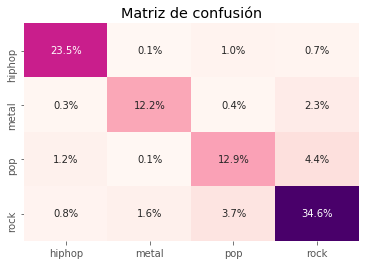

In [23]:
y_hat = pipeline_model.predict(X_test)

print(classification_report(y_test, y_hat))

cnf = confusion_matrix(y_test, y_hat) / len(y_test)
plt.title('Matriz de confusión')
sns.heatmap(cnf, xticklabels=pipeline_model.classes_, yticklabels=pipeline_model.classes_, annot=True, fmt=".1%", cbar=False, cmap='RdPu');

### Comentarios: 

La precisión de cada género es:

- hiphop: 91%.
- metal: 87%
- pop: 72%
- rock: 82%

La precisión más baja la tiene el pop y el rock. En el caso del pop mejoró varios puntos porcentuales, el cambio más grande fue en el recall del pop. Viendo la matriz de confusión, podemos ver que el modelo mejoró (de 65% a 83%)